(mmm_time_slice_cross_validation)=
# Time-Slice-Cross-Validation and Parameter Stability

In this notebook we will illustrate how to perform time-slice cross validation for a media mix model. This is an important step to evaluate the stability and quality of the model. We not only look into out of sample predictions but also the stability of the model parameters.

## Prepare Notebook

In [2]:
import warnings
from dataclasses import dataclass

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns
import logging
import numpyro
import pprint
from itertools import combinations

from pymc_marketing.metrics import crps
from pymc_marketing.mmm import (
    MMM,
    GeometricAdstock,
    LogisticSaturation,
)
from pymc_marketing.mmm.utils import apply_sklearn_transformer_across_dim
from pymc_marketing.paths import data_dir
from pymc_marketing.prior import Prior

warnings.simplefilter(action="ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"


%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

# Specify path for output data
output_path = data_dir / "output"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Read Data

We use the same data as in the example notebook {ref}`mmm_example`.

In [4]:
raw_df = pd.read_csv("/Users/shua0225/MMM/mmm_data_wide_042425.csv")
# Ensure 'day_dt' is in datetime format
raw_df["day_dt"] = pd.to_datetime(raw_df["day_dt"], errors="coerce")
raw_df.columns

Index(['day_dt', 'channel_app_imps', 'channel_hmi_audio_imps',
       'channel_hmi_display_imps', 'channel_hmi_linear_imps',
       'channel_hmi_ooh_imps', 'channel_hmi_video_imps',
       'channel_influencer_imps', 'channel_macs_programmatic_imps',
       'channel_macs_social_imps', 'channel_oo_display_imps',
       'channel_oo_linear_imps', 'channel_oo_video_imps',
       'channel_paid_search_imps', 'channel_partnerships_imps',
       'channel_podcast_one_imps', 'channel_app_spend',
       'channel_hmi_audio_spend', 'channel_hmi_display_spend',
       'channel_hmi_linear_spend', 'channel_hmi_ooh_spend',
       'channel_hmi_video_spend', 'channel_influencer_spend',
       'channel_macs_programmatic_spend', 'channel_macs_social_spend',
       'channel_oo_display_spend', 'channel_oo_linear_spend',
       'channel_oo_video_spend', 'channel_paid_search_spend',
       'channel_partnerships_spend', 'channel_podcast_one_spend',
       'y_returning', 'y_new_winback', 'y_total_qdau', 'weekday_

In [5]:

# Map the event dictionary of notable events
# look for holidays that start on weekends and could have a holiday effect on the following Monday
events_dict = {
    "2023-01-01": "ny23_2023",
    "2023-01-16": "mlk_2023",
    "2023-02-12": "superbowl_2023",
    "2023-02-13": "day_after_superbowl_2023",
    "2023-02-20": "pres_2023",
    "2023-03-24": "anomaly_3_24_23",  # roku stitcher bug start
    "2023-03-25": "anomaly_3_25_23",
    "2023-03-26": "anomaly_3_26_23",
    "2023-03-27": "anomaly_3_27_23",
    "2023-03-28": "anomaly_3_28_23",  # roku stitcher bug end
    "2023-05-29": "mem_2023",
    "2023-06-19": "juneteenth_2023",
    "2023-07-04": "ind_2023",
    "2023-09-04": "lab_2023",
    "2023-11-23": "thanks_2023",
    "2023-11-24": "blk_fri_2023",
    "2023-12-17": "anomaly_12_17_23",  # bug
    "2023-12-20": "anomaly_12_20_2023",  # bug
    "2023-12-21": "anomaly_12_21_2023",  # bug
    "2023-12-23": "day_b4_xmas_eve_2023",
    "2023-12-24": "xmas_eve_2023",
    "2023-12-25": "xmas_2023",
    "2023-12-26": "xmas_day_after_2023",
    "2023-12-30": "day_b4_nye_2023",
    "2023-12-31": "nye_2023",
    "2024-01-01": "ny24_2024",
    "2024-01-15": "mlk_2024",
    "2024-02-11": "anomaly_2_11_2024",  # bug
    "2024-02-19": "pres_2024",
    "2024-03-12": "anomaly_3_11_2024",  # bug
    "2024-03-12": "anomaly_3_12_2024",  # bug
    "2024-03-13": "anomaly_3_13_2024",  # bug
    "2024-03-14": "anomaly_3_14_2024",  # bug
    "2024-03-15": "anomaly_3_15_2024",  # bug
    "2024-05-27": "mem_2024",
    "2024-06-19": "juneteenth_2024",
    "2024-07-04": "ind_2024",
    "2024-09-02": "lab_2024",
    "2024-11-28": "thanks_2024",
    "2024-11-29": "blk_fri_2024",
    "2024-12-24": "xmas_eve_2024",
    "2024-12-25": "xmas_2024",
    "2024-12-31": "nye_2024",
    "2024-02-11": "superbowl_2024",
    "2024-02-12": "day_after_superbowl_2024",
}



# Map the event names to the 'event' column
raw_df['event'] = pd.to_datetime(raw_df['day_dt'], errors='coerce').dt.strftime('%Y-%m-%d').map(events_dict)


/var/folders/kp/4w7zhccj5y15dty978bdp_1r0000gp/T/ipykernel_6510/3561271359.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


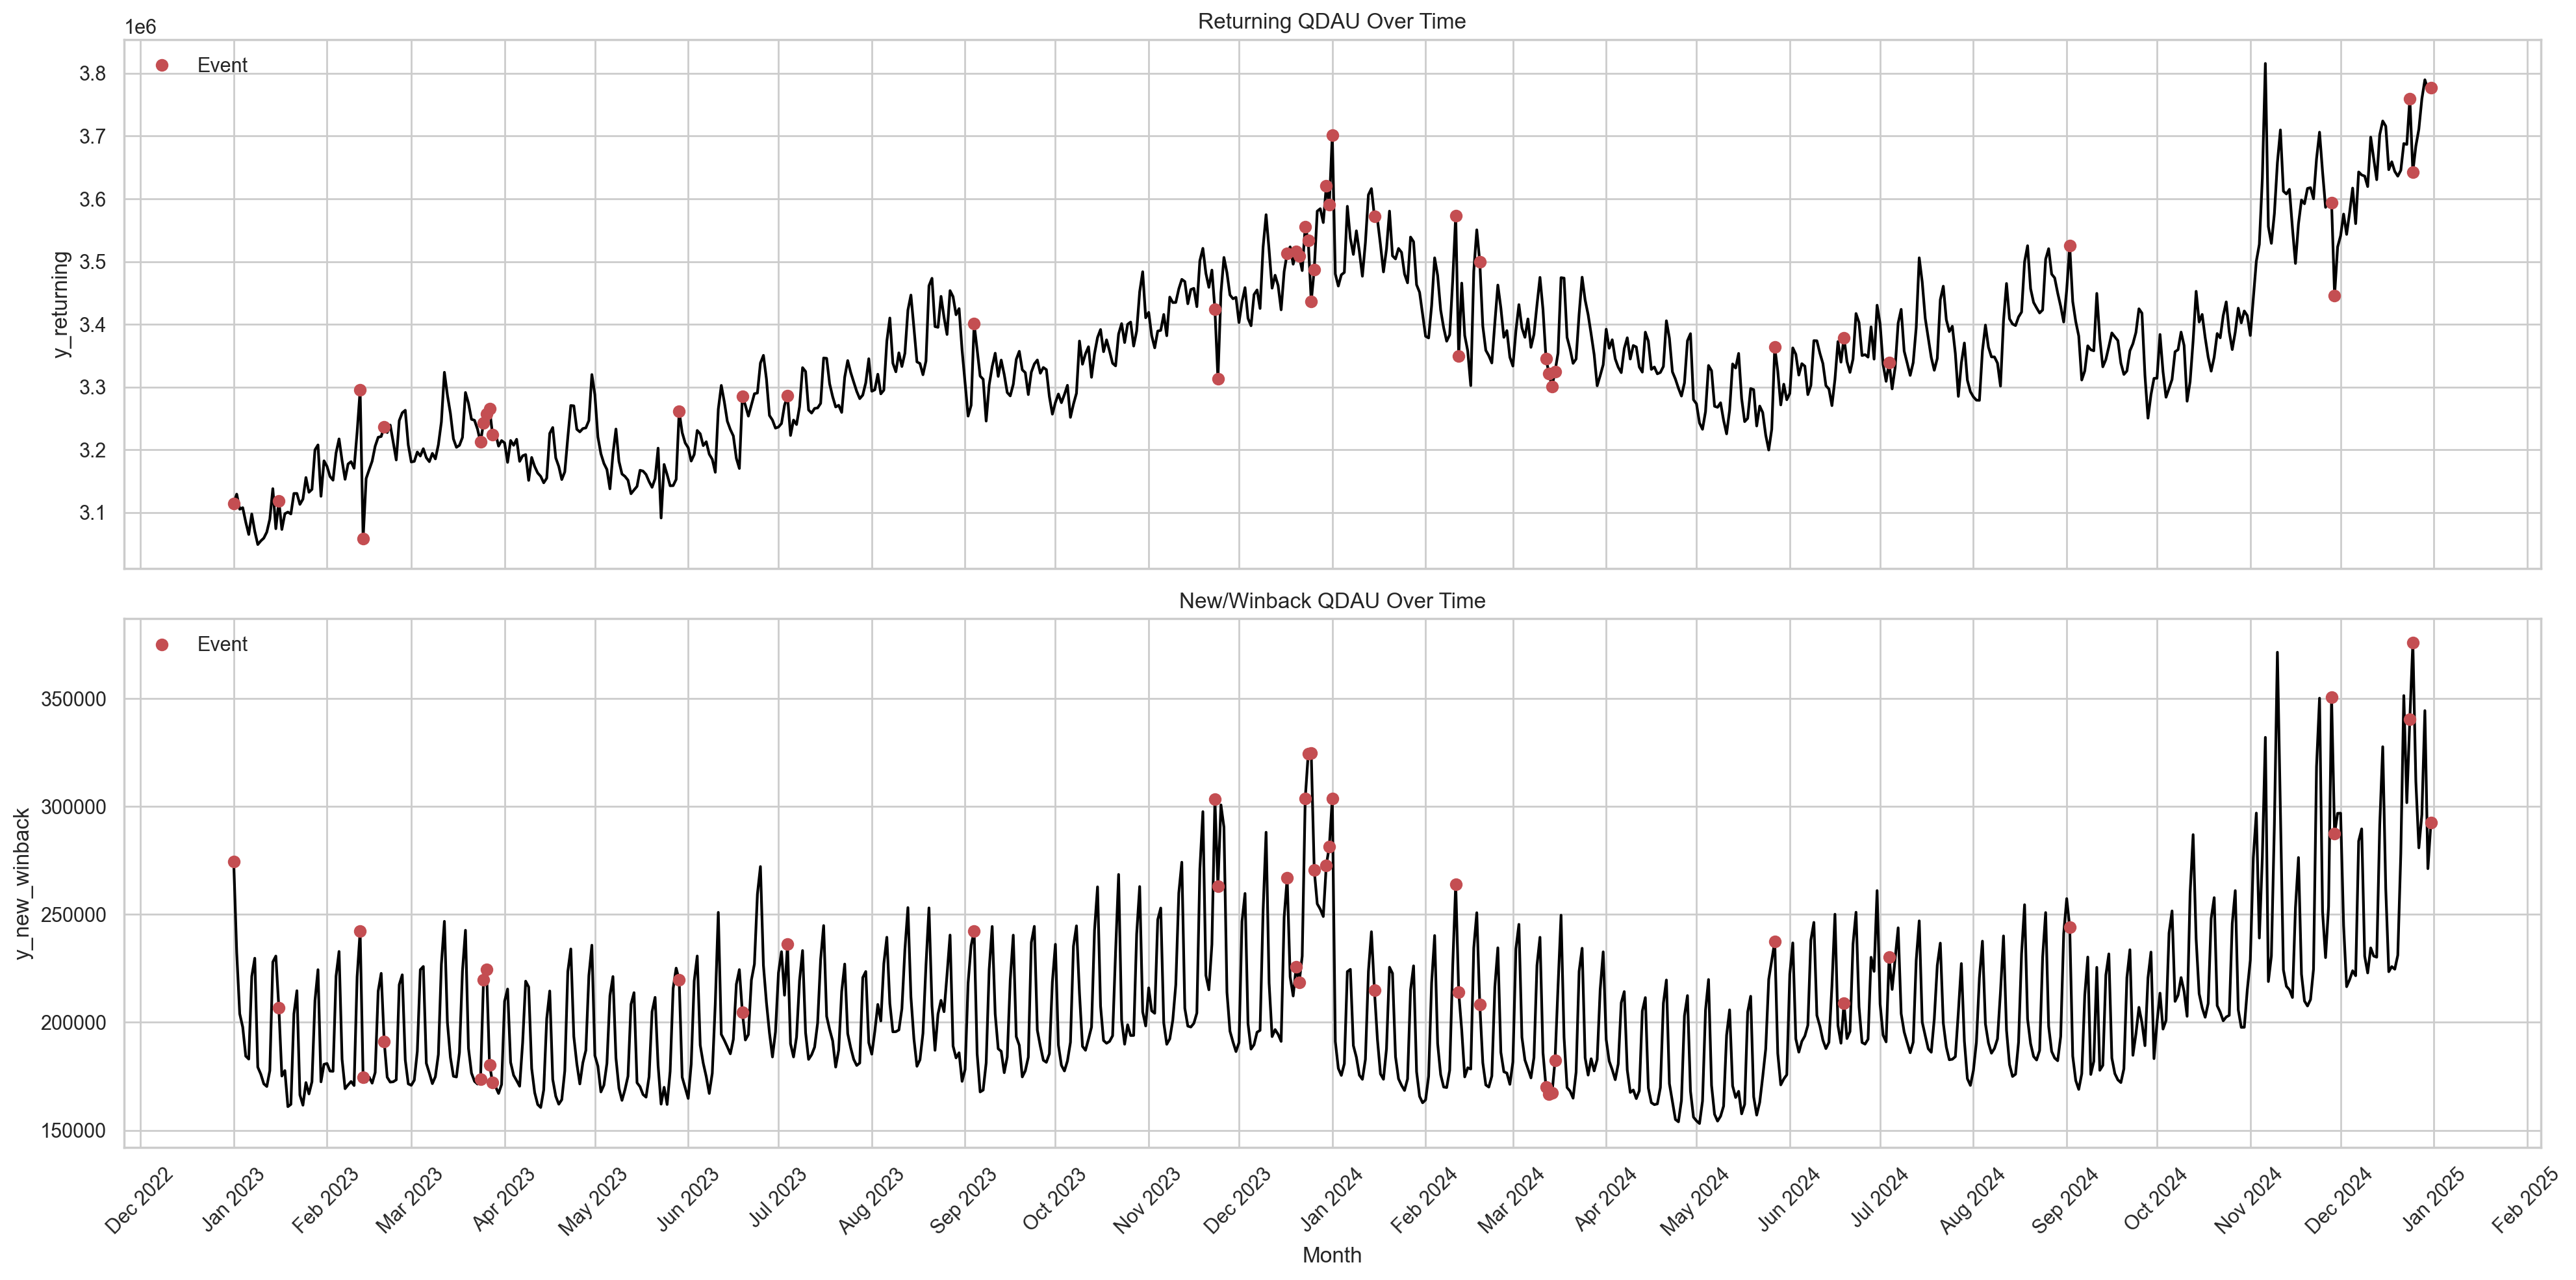

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd

# One-hot encode events
event_dummies = pd.get_dummies(raw_df["event"], prefix="event_", prefix_sep="")
event_dummies = (event_dummies >= 1).astype(int)
daily_df = pd.concat([raw_df, event_dummies], axis=1).sort_values("day_dt").reset_index(drop=True)

# One-hot encode day of week
dow_dummies = pd.get_dummies(daily_df["day_dt"].dt.dayofweek, prefix="dow_", prefix_sep="")
dow_dummies = (dow_dummies >= 1).astype(int)
daily_df = pd.concat([daily_df, dow_dummies], axis=1)

# Set plot style
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10), sharex=True)

# Define variables to plot
metrics = [("y_returning", "Returning QDAU Over Time"), ("y_new_winback", "New/Winback QDAU Over Time")]

for ax, (col, title) in zip(axes, metrics):
    sns.lineplot(data=daily_df, x="day_dt", y=col, color="black", ax=ax)
    event_days = daily_df[pd.notna(daily_df["event"])]
    ax.plot(event_days["day_dt"], event_days[col], "ro", markersize=6, label="Event")
    ax.set(title=title, xlabel="Month", ylabel=col)
    ax.legend()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# add a linear trend to the data
daily_df['t'] = np.arange(len(daily_df))

In [8]:
daily_df.columns

Index(['day_dt', 'channel_app_imps', 'channel_hmi_audio_imps',
       'channel_hmi_display_imps', 'channel_hmi_linear_imps',
       'channel_hmi_ooh_imps', 'channel_hmi_video_imps',
       'channel_influencer_imps', 'channel_macs_programmatic_imps',
       'channel_macs_social_imps', 'channel_oo_display_imps',
       'channel_oo_linear_imps', 'channel_oo_video_imps',
       'channel_paid_search_imps', 'channel_partnerships_imps',
       'channel_podcast_one_imps', 'channel_app_spend',
       'channel_hmi_audio_spend', 'channel_hmi_display_spend',
       'channel_hmi_linear_spend', 'channel_hmi_ooh_spend',
       'channel_hmi_video_spend', 'channel_influencer_spend',
       'channel_macs_programmatic_spend', 'channel_macs_social_spend',
       'channel_oo_display_spend', 'channel_oo_linear_spend',
       'channel_oo_video_spend', 'channel_paid_search_spend',
       'channel_partnerships_spend', 'channel_podcast_one_spend',
       'y_returning', 'y_new_winback', 'y_total_qdau', 'weekday_

# Specify Variables in the Model

In [9]:


# 1. control variables
# We just keep the holidays columns
control_columns = [col for col in daily_df.columns if col.startswith("event_") or col.startswith("dow_")]
print("Control columns:", control_columns)

# 2. media variables
# Impressions only for now
media_activity = "imps" # must be "imps" or "spend"
channel_columns_raw = sorted(
    [
        col
        for col in daily_df.columns
        if ("channel_" in col) & (f"_{media_activity}" in col)
    ]
)

imps_channel_mapping = {
    "channel_app_imps": "MACS App",
    "channel_hmi_audio_imps": "HMI Audio",
    "channel_hmi_display_imps": "HMI Display",
    "channel_hmi_linear_imps": "HMI Linear",
    "channel_hmi_ooh_imps": "HMI OOH",
    "channel_hmi_video_imps": "HMI Digital Video",
    "channel_influencer_imps": "Influencer",
    "channel_macs_programmatic_imps": "MACS Programmatic",
    "channel_macs_social_imps": "MACS Social",
    "channel_oo_display_imps": "OO Display",
    "channel_oo_linear_imps": "OO Linear",
    "channel_oo_video_imps": "OO Video",
    "channel_paid_search_imps": "Paid Search",
    "channel_partnerships_imps": "Partnerships",
    "channel_podcast_one_imps": "Podcast One Audio",
}



spend_channel_mapping = {
    "channel_app_spend": "MACS App",
    "channel_hmi_audio_spend": "HMI Audio",
    "channel_hmi_display_spend": "HMI Display",
    "channel_hmi_linear_spend": "HMI Linear",
    "channel_hmi_ooh_spend": "HMI OOH",
    "channel_hmi_video_spend": "HMI Digital Video",
    "channel_influencer_spend": "Influencer",
    "channel_macs_programmatic_spend": "MACS Programmatic",
    "channel_macs_social_spend": "MACS Social",
    "channel_oo_display_spend": "OO Display",
    "channel_oo_linear_spend": "OO Linear",
    "channel_oo_video_spend": "OO Video",
    "channel_paid_search_spend": "Paid Search",
    "channel_partnerships_spend": "Partnerships",
    "channel_podcast_one_spend": "Podcast One Audio",
}

if media_activity == "imps":
    channel_mapping = imps_channel_mapping
    channel_columns = sorted(list(imps_channel_mapping.keys()))
    
else:
    channel_mapping = spend_channel_mapping
    channel_columns = sorted(list(spend_channel_mapping.keys()))
    
channel_names = sorted(list(imps_channel_mapping.values()))

print("Channel columns:", channel_names)



# 3. y variable
y_var = "y_new_winback"

data_df = daily_df[["day_dt", y_var, *channel_columns, *control_columns]]
data_df = data_df.rename(columns=channel_mapping)

# reorder the channel columns in data_df only
sorted_channel_columns = sorted(channel_mapping.values())
data_df = data_df[['day_dt', y_var, *sorted_channel_columns, *control_columns]]

# 4. Date column
data_df["day_dt"] = pd.to_datetime(data_df["day_dt"])
date_column = "day_dt"
data_df.columns

# remove event_0 column
if "event_0" in data_df.columns:
    data_df = data_df.drop(columns=["event_0"])

Control columns: ['event_anomaly_12_17_23', 'event_anomaly_12_20_2023', 'event_anomaly_12_21_2023', 'event_anomaly_3_12_2024', 'event_anomaly_3_13_2024', 'event_anomaly_3_14_2024', 'event_anomaly_3_15_2024', 'event_anomaly_3_24_23', 'event_anomaly_3_25_23', 'event_anomaly_3_26_23', 'event_anomaly_3_27_23', 'event_anomaly_3_28_23', 'event_blk_fri_2023', 'event_blk_fri_2024', 'event_day_after_superbowl_2023', 'event_day_after_superbowl_2024', 'event_day_b4_nye_2023', 'event_day_b4_xmas_eve_2023', 'event_ind_2023', 'event_ind_2024', 'event_juneteenth_2023', 'event_juneteenth_2024', 'event_lab_2023', 'event_lab_2024', 'event_mem_2023', 'event_mem_2024', 'event_mlk_2023', 'event_mlk_2024', 'event_ny23_2023', 'event_ny24_2024', 'event_nye_2023', 'event_nye_2024', 'event_pres_2023', 'event_pres_2024', 'event_superbowl_2023', 'event_superbowl_2024', 'event_thanks_2023', 'event_thanks_2024', 'event_xmas_2023', 'event_xmas_2024', 'event_xmas_day_after_2023', 'event_xmas_eve_2023', 'event_xmas_ev

In [ ]:
# melt the data_df
melted_df = data_df.melt(
    id_vars=[date_column],
    value_vars=channel_names,
    var_name="channel",
    value_name="impressions",
)

# aggregate impressions by month for each channel
melted_df["month"] = melted_df[date_column].dt.to_period("M")
monthly_impressions = melted_df.groupby(["month", "channel"])["impressions"].sum().reset_index()

display(monthly_impressions)

# write to csv
monthly_impressions.to_csv(output_path / "monthly_impressions.csv", index=False)

,month,channel,impressions
0,2023-01,HMI Audio,1.749006e+08
1,2023-01,HMI Digital Video,1.045209e+07
2,2023-01,HMI Display,1.754000e+03
3,2023-01,HMI Linear,9.006157e+06
4,2023-01,HMI OOH,7.676037e+06
...,...,...,...
355,2024-12,OO Linear,2.680200e+07
356,2024-12,OO Video,9.548812e+07
357,2024-12,Paid Search,5.147376e+07
358,2024-12,Partnerships,1.545482e+09


/var/folders/kp/4w7zhccj5y15dty978bdp_1r0000gp/T/ipykernel_2400/172839320.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  melted_contrib["month"] = pd.to_datetime(melted_contrib["month"]).dt.to_period("M")
/var/folders/kp/4w7zhccj5y15dty978bdp_1r0000gp/T/ipykernel_2400/172839320.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


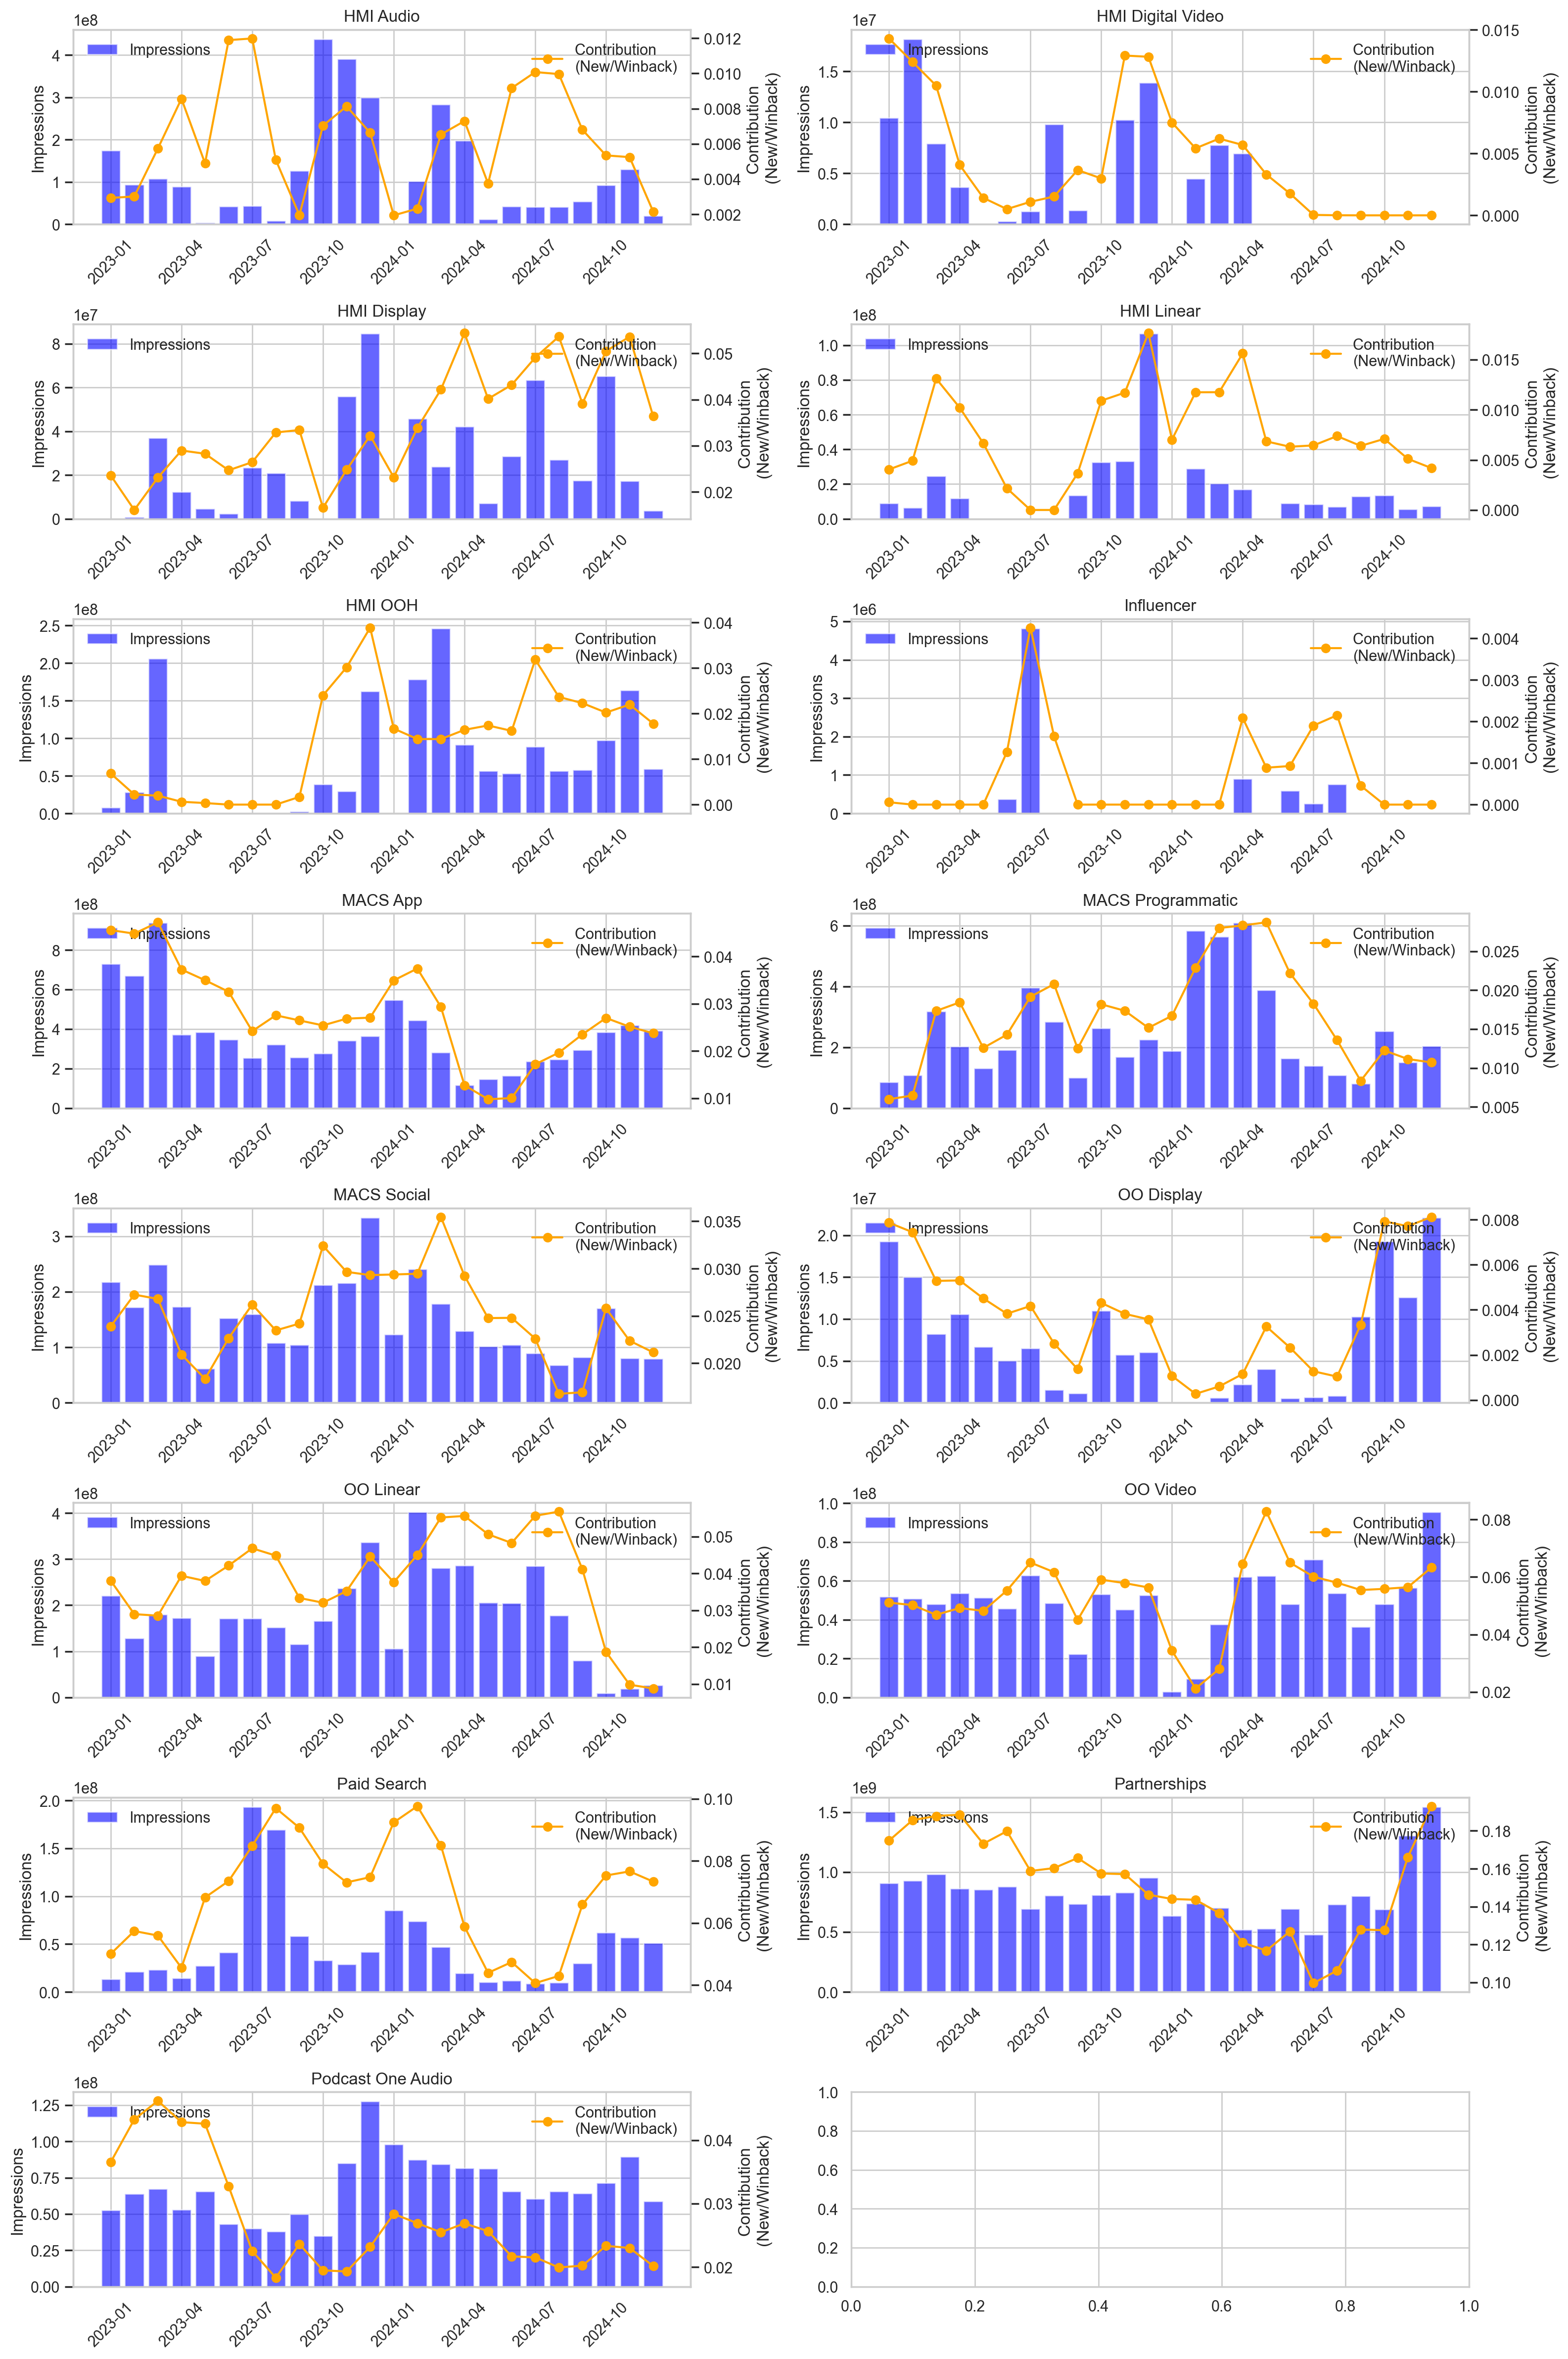

In [16]:
# read in media contributions from deloitte
raw_contrib = pd.read_csv("/Users/shua0225/MMM/monthly_contributions_deloitte.csv")
raw_contrib = raw_contrib.rename(columns={"Month": "month"})

# melt the data
melted_contrib = raw_contrib.melt(
    id_vars=["month"],
    var_name="channel",
    value_name="contribution",
)

# convert month to datetime
melted_contrib["month"] = pd.to_datetime(melted_contrib["month"]).dt.to_period("M")


# join monthly_impressions and melted_contrib
joined = monthly_impressions.merge(
    melted_contrib,
    on=["month", "channel"],
    how="left",
)


# Plot with secondary y-axis for contribution
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(16, 24))
axes = axes.flatten()

for i, channel in enumerate(joined["channel"].unique()):
    channel_data = joined[joined["channel"] == channel]
    axes[i].bar(channel_data["month"].astype(str), channel_data["impressions"], label="Impressions", color="blue", alpha=0.6)
    axes[i].set_ylabel("Impressions")
    axes[i].set_title(channel)
    
    # Create a secondary y-axis for contribution
    ax2 = axes[i].twinx()
    ax2.plot(channel_data["month"].astype(str), channel_data["contribution"], label="Contribution \n(New/Winback)", color="orange", marker='o')
    ax2.set_ylabel("Contribution \n(New/Winback)")
    
    # Set x-axis ticks
    axes[i].set_xticks(channel_data["month"].astype(str)[::3])
    axes[i].set_xticklabels(channel_data["month"].astype(str)[::3], rotation=45)
    axes[i].legend(loc="upper left")
    ax2.legend(loc="upper right")

    # remove the grid lines for the secondary y-axis
    ax2.grid(False)
plt.tight_layout()
plt.show()

/var/folders/kp/4w7zhccj5y15dty978bdp_1r0000gp/T/ipykernel_2400/3256846306.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


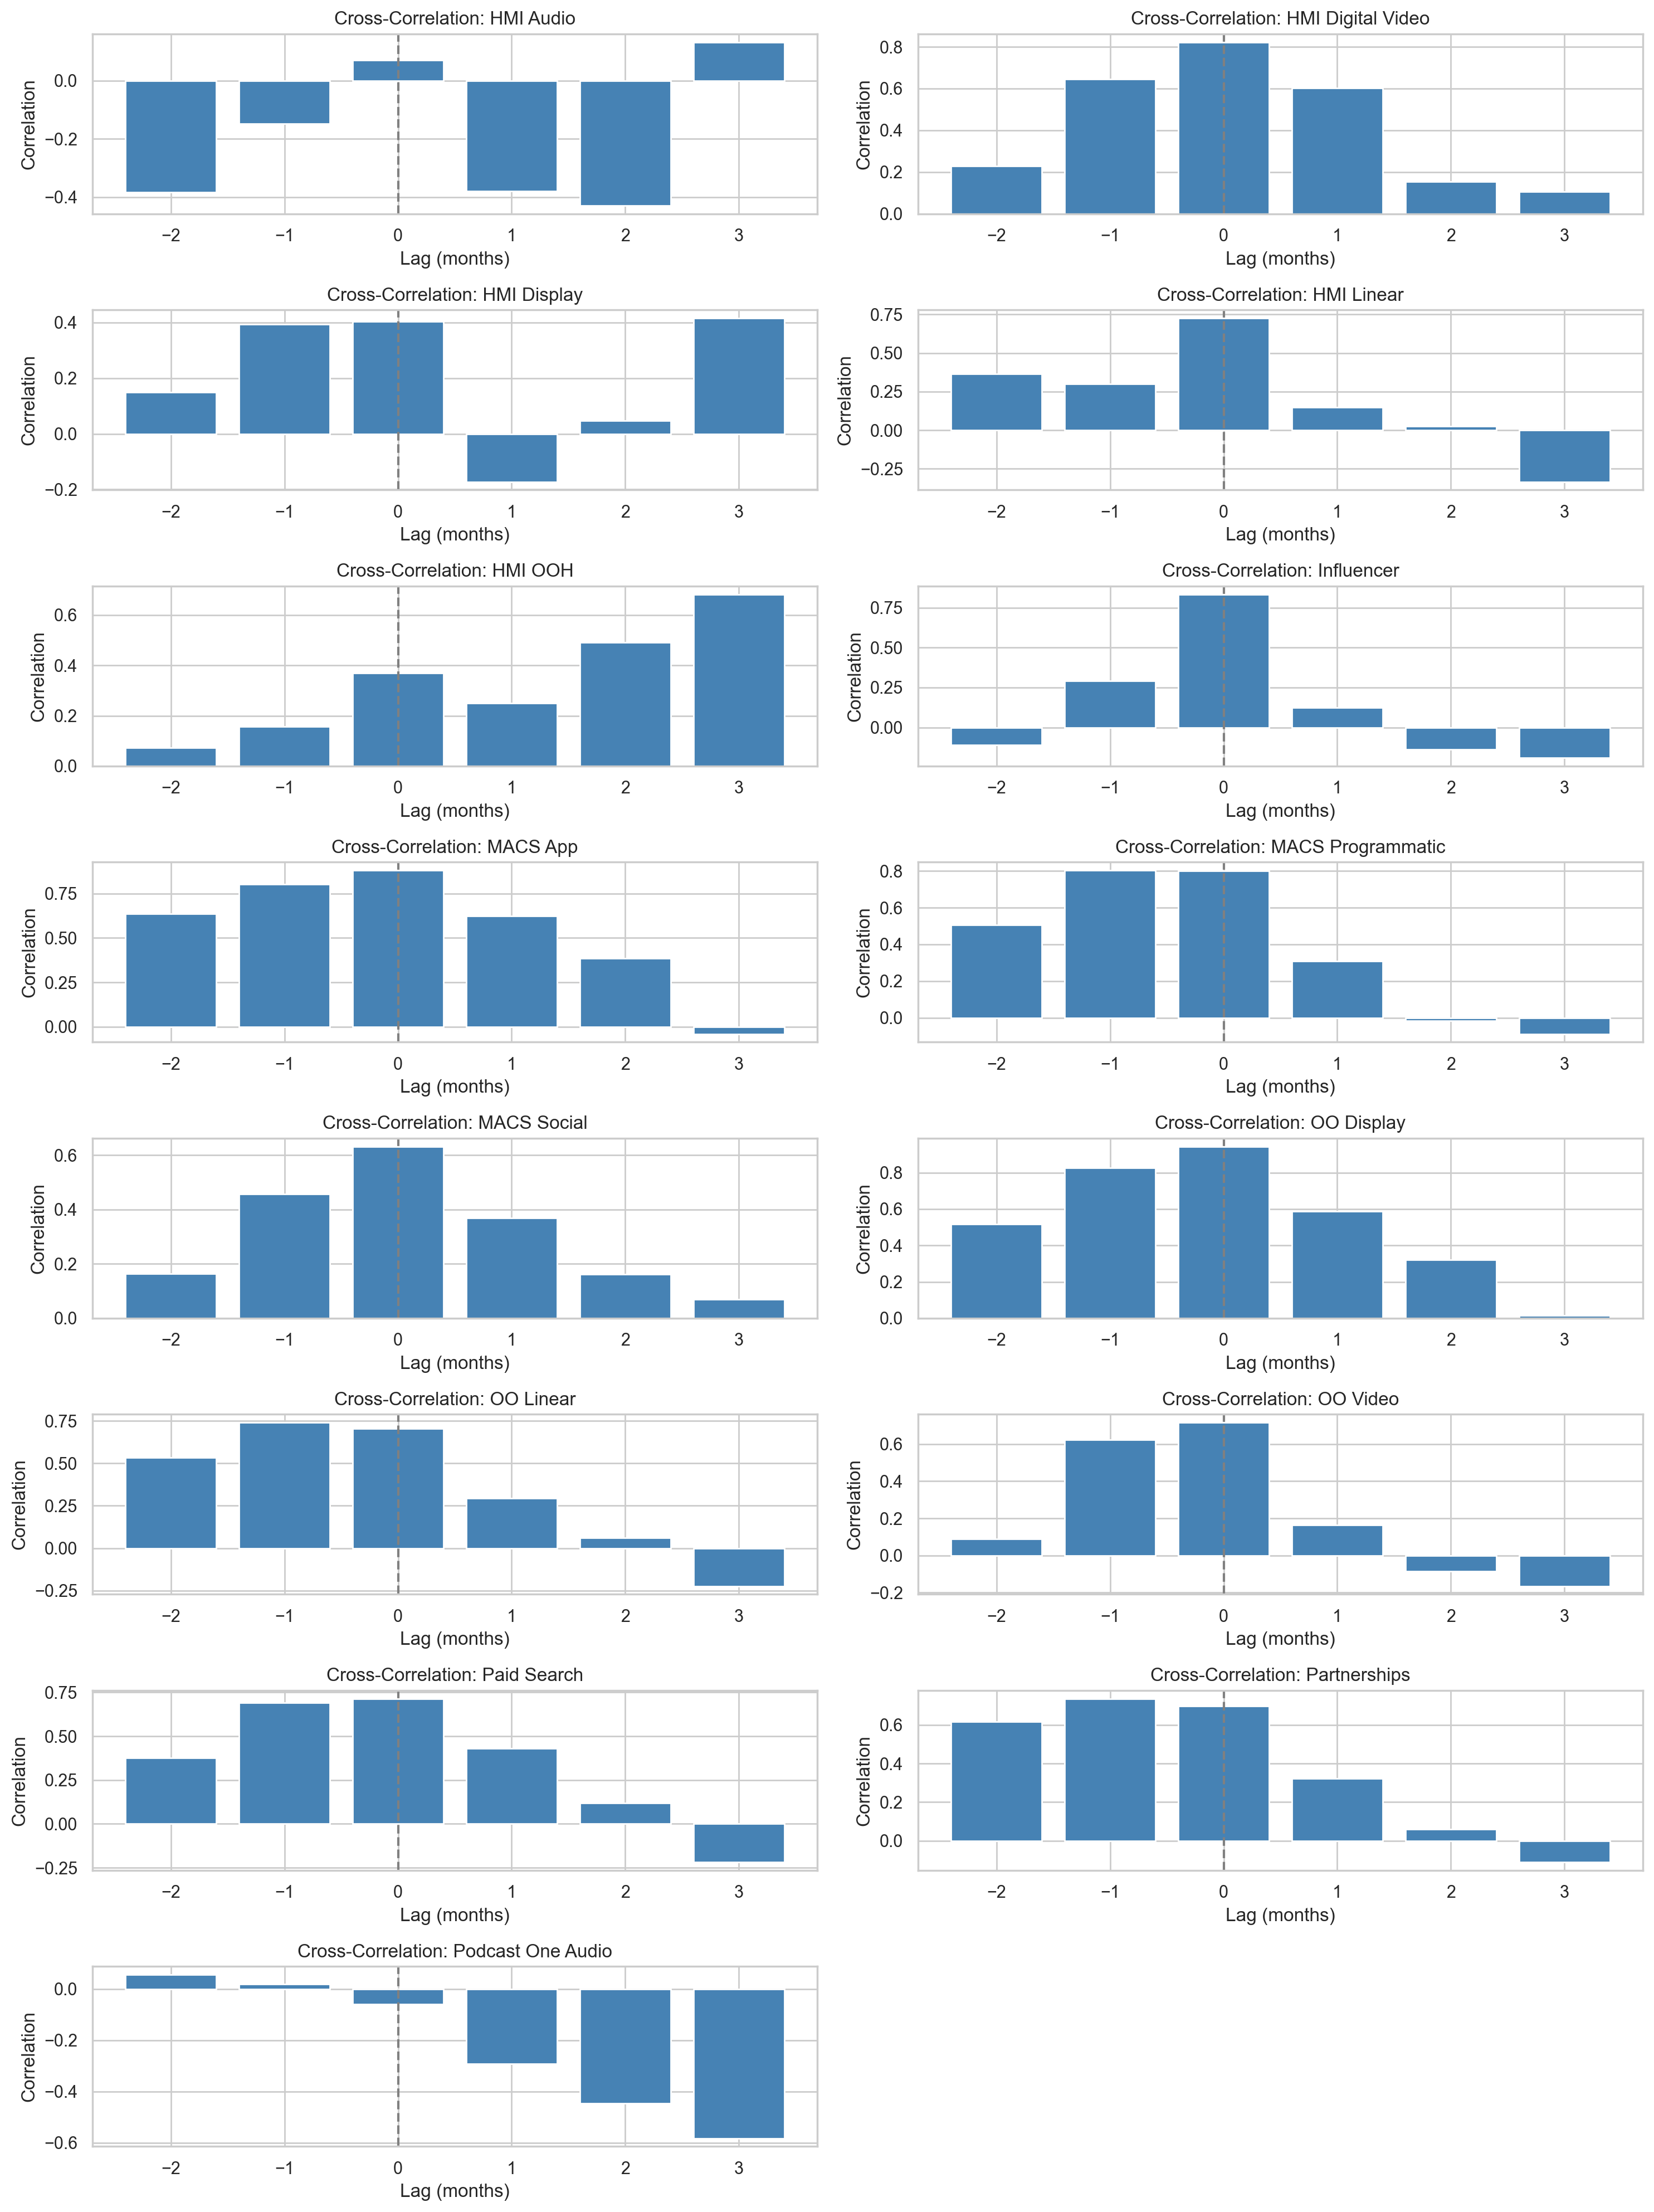

In [18]:
import math

# Determine number of rows needed for 2 plots per row
n_cols = 2
n_rows = math.ceil(len(channel_names) / n_cols)

# Prepare figure with adjusted grid layout
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 2.5 * n_rows))
axes = axes.flatten()
lags = np.arange(-2, 4, 1)  # Lags from -6 to 6 months

# Plot CCF for each channel
for i, channel in enumerate(channel_names):
    ax = axes[i]
    df_channel = joined[joined["channel"] == channel].copy()

    corrs = []
    for lag in lags:
        shifted = df_channel["impressions"].shift(-lag)
        corr = df_channel["contribution"].corr(shifted)
        corrs.append(corr)

    ax.bar(lags, corrs, color="steelblue")
    ax.axvline(0, color="gray", linestyle="--")
    ax.set_title(f"Cross-Correlation: {channel}")
    ax.set_xlabel("Lag (months)")
    ax.set_ylabel("Correlation")
    ax.grid(True)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
